In [1]:
import sys
sys.path.insert(1, '../')

In [2]:
import matplotlib.pyplot as plt

In [3]:
from methods.DataDrivenMethods import DDMethod
from solvers.Solver import Solver
import numpy as np
from sklearn.model_selection import train_test_split
import torch

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

In [5]:
nx = 101

In [6]:
params_solver = {'equation': 'Poisson', 
                 'domain': [0, 1], 
                 'D': 0.1,
                 'nx': nx,
                 'source term' : lambda x : np.ones_like(x)}

In [7]:
params_branch = {'layer_dims': [1, 60, 60, 60],
                 'activations': 'tanh', 
                 'device': device, 
                 'seed': 123, 
                 'method_name': 'MLP'}

params_trunk = {'layer_dims': [1, 60, 60, 60],
                 'activations': 'tanh', 
                 'device': device, 
                 'seed': 123, 
                 'method_name': 'MLP'}

In [8]:
params = {'solver' : params_solver, 
          'method' : {'branch' : params_branch, 'trunk' : params_trunk, 'method_name': 'DEEPONET'}}
solver = Solver(params=params)

In [9]:
model = DDMethod(params=params)

In [10]:
model._method

DeepONet(
  (branch): MLP(
    (_layers): ModuleList(
      (0): Linear(in_features=1, out_features=60, bias=True)
      (1-2): 2 x Linear(in_features=60, out_features=60, bias=True)
    )
  )
  (trunk): MLP(
    (_layers): ModuleList(
      (0): Linear(in_features=1, out_features=60, bias=True)
      (1-2): 2 x Linear(in_features=60, out_features=60, bias=True)
    )
  )
)

In [11]:
Dmin, Dmax = 1, 10
num_D = 1000

D_list = (Dmax - Dmin)* np.random.rand(num_D, 1) + Dmin

In [12]:
U_sols = []

for d in D_list:
    solver.change_D(new_D=d)
    U_sols.append(solver.solve())

U_sols = np.stack(U_sols)

In [13]:
d_train, d_val, u_train, u_val = train_test_split(D_list, U_sols, test_size=0.2, random_state=123)

In [14]:
x = solver.x.reshape(-1, 1)

In [15]:
train_data = [d_train, x, u_train]
val_data = [d_val, x, u_val]

In [16]:
hyperparameters = {'lr': 1e-3, 'epochs': 10000, 'optimizer': 'Adam'}

In [17]:
model.fit(hyperparameters = hyperparameters,
          train_data = train_data, val_data = val_data)

Fitting DEEPONET


[tr : 1.9e-06, val : 1.4e-06]: 100%|█████| 10000/10000 [00:34<00:00, 291.92it/s]

DEEPONET fitted


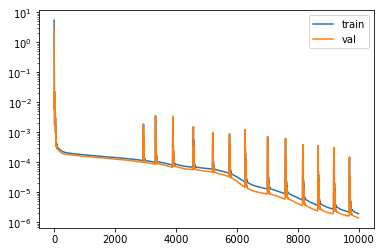

In [18]:
plt.yscale('log')

plt.plot(model._method._losses['train'], label = 'train')
plt.plot(model._method._losses['val'], label = 'val')

plt.legend()
plt.show()

In [19]:
test = model.apply_method(d_val[0])

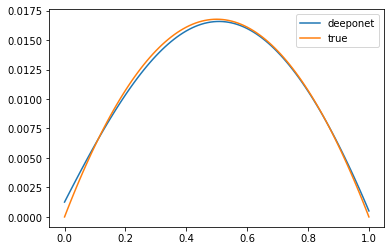

In [22]:
plt.plot(solver.x, test.squeeze(), label ='deeponet')
plt.plot(solver.x, u_val[0, :], label = 'true')

plt.legend()
plt.show()